# Expectation Maximisation: estimating bias from coin flips

This example is based on the article *[What is the expectation maximization
algorithm?](https://www.nature.com/nbt/journal/v26/n8/pdf/nbt1406.pdf)* by Do & Batzoglou.

## Setup

Suppose we have two coins, A and B. Suppose also that we have several sequences of coin flips, each generated by flipping either coin A or coin B some number of times:

In [1]:
# N.B. each coin label in `labels` corresponds to the sequence of flips at the same index in `flip_seqs`

labels = ['B', 'A', 'A', 'B', 'A']

flip_seqs = ['HTHHHTTHHHHTHHHTTHHHHHTHHHHH',
             'HHTHHHHHTTTTTTTHHTT',
             'HTHHHHTTHHTTTTTTTHTTTTHHTTT',
             'HTHTTHHTTHHHHHTHHHHHHHTHHHHHTHHHHHHTTHHHHH',
             'THHHTHHHTHTTTTTTTTTT']

## Probability of heads

Call the probability of a coin landing heads $\theta$. This parameter may be $0.5$ (a fair coin), or it could be higher (we should see more heads), or lower (we should see fewer heads).

We can estimate this parameter for each coin separately from our data using the formula

$$\theta = \frac{H}{H+T}$$

where $H$ is the total number of heads and $T$ is the total number of tails seen across the flip sequences for each coin. Here's a Python function to do exactly this:

In [2]:
def estimate_theta(H, T):
    """
    Fraction of heads given H heads and T tails.
    """
    return H / (H + T)

Very simple. To use it, we just need to count the number of heads and tails across the sequences for each of the labels A and B.

In [3]:
from collections import Counter, defaultdict

count_dict = defaultdict(Counter)

for label, seq in zip(labels, flip_seqs):
    count_dict[label] += Counter(seq)
    
print('Coin A: there were {H} heads and {T} tails across the flip sequences'.format(**count_dict['A']))
print('Coin B: there were {H} heads and {T} tails across the flip sequences'.format(**count_dict['B']))

Coin A: there were 26 heads and 40 tails across the flip sequences
Coin B: there were 53 heads and 17 tails across the flip sequences


So we estimate $\theta_A$ to be:

In [4]:
estimate_theta(**count_dict['A'])

0.3939393939393939

And we estimate $\theta_B$ to be:

In [5]:
estimate_theta(**count_dict['B'])

0.7571428571428571

## Likelihood functions

The values above are the **maximum likelihood** estimates for $\theta_A$ and $\theta_B$. They are the values that are most likely to produce the counts of heads and tails we observed for each coin. They maximise the **likelihood function** for A and for B (no other input value to the function would yield a greater output).

What is a likelihood function? It tells you, given some data and a parameter, how well the parameter fits the data. In other words, how likely the parameter is be "correct".

What is the likelihood function in this coin flip example?

Recall that the [binomial formula](https://en.wikipedia.org/wiki/Binomial_distribution#Probability_mass_function) computes the probability that we have $H$ successes in $H+T$ independent trials, given that the proability of success is $\theta$:

$$p(H,T  \mid \theta)=\left({H+T \atop H}\right) \theta^H (1-\theta)^T$$

By [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can also use this formula to compute the probability of $\theta$ given $H$ heads and $T$ tails, i.e. $p(\theta \mid H, T) = p(H,T  \mid \theta) \cdot k$.

We're making the assumption here that $k$ is constant because it is reasonable to treat $p(\theta)$ as constant (prior to the experiment we think that one possible value for $\theta$ is just as probable as another).

Unlike a probability function, a likelihood function does not need to produce a value between 0 and 1. All we're interested in here is making it as large as possible for our choice of $\theta$ which means we can just ignore constant multipliers like $k$ and $\left({H+T \atop H}\right)$.

So the likelihood of $\theta$, given we saw $H$ heads and $T$ tails, can just be expressed as

$$L(\theta \mid H, T)=\theta^H (1-\theta)^{T}$$

Here's a Python function to compute the likelihood of $\theta$ given $H$ and $T$:

In [6]:
def likelihood_of_theta(theta, H, T):
    """
    Likelihood of theta, given that we saw H heads and T tails.
    """
    return theta**H * (1 - theta)**T

If we plot $L(\theta \mid H, T)$ for all values of $\theta$ between 0 and 1, we can see that $\frac{H}{H+T}$ does indeed give find the value of $\theta$ that produces the maximum likelihood (the dotted vertical line in the plot below):

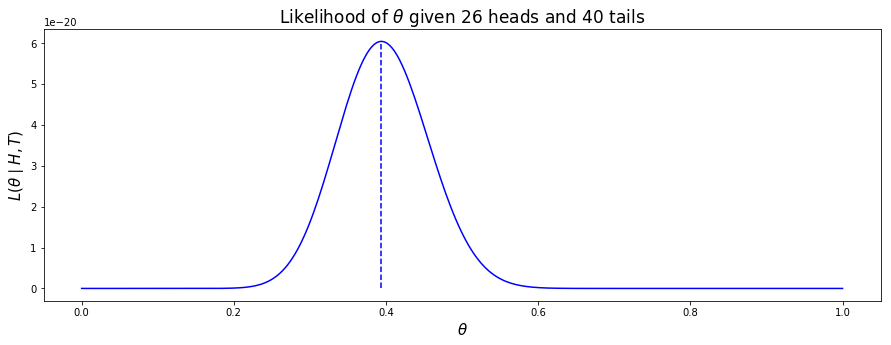

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

counts = count_dict['A']

H = counts['H']
T = counts['T']

theta = np.linspace(0, 1, 300)
theta_likelihood = likelihood_of_theta(theta, H, T)

# compute maximum likelihood estimate
m = estimate_theta(H, T)
m_likelihood = likelihood_of_theta(m, H, T)

# plot
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(theta, theta_likelihood, color='b');
plt.vlines(m, 0, m_likelihood, 'b', '--');
plt.title(r'Likelihood of $\theta$ given {} heads and {} tails'.format(H, T), fontsize=17);
plt.ylabel(r'$L(\theta \mid H,T)$', fontsize=15);
plt.xlabel(r'$\theta$', fontsize=15);

*N.B. curve may no be drawn completely accurately if values for $H$ or $T$ are large, given limited precision of floating-point values.*

If you want to read more about switching from $p(\theta \mid H, T)$ to $p(H,T  \mid \theta)$ (and the connection with the Beta distribution which I did not mention above) you may find the short blog post [Bayesian inference for a binomial proportion](https://stephens999.github.io/fiveMinuteStats/bayes_beta_binomial.html) by Matthew Stephens helpful.

Note: to derive the formula $\frac{H}{H+T}$ analytically, differentiate $L$ with respect to $\theta$ and find the stationary points in terms of $H$ and $T$.

## Hidden labels

Now suppose that we've lost the labels for the coin flips. 

In other words, we know that we have two coins and that they have been flipped to produce these sequences of flips: 

In [8]:
print(*flip_seqs, sep='\n')

HTHHHTTHHHHTHHHTTHHHHHTHHHHH
HHTHHHHHTTTTTTTHHTT
HTHHHHTTHHTTTTTTTHTTTTHHTTT
HTHTTHHTTHHHHHTHHHHHHHTHHHHHTHHHHHHTTHHHHH
THHHTHHHTHTTTTTTTTTT


...but the label of each coin is now a *hidden variable*. 

The function `estimate_theta()` is unable to compute our maximum likelihood estimates for $\theta_A$ and $\theta_B$ because as we do not know the true counts of heads and tails for each coin.

## Expectation Maximisation

All is not lost. We can use **Expectation Maximisation** (EM) to estimate the parameter values that are most likely to produce the data we have observed. 

This method is not guaranteed to produce the exact same values we'd derive if we *could* see the labels, but it may well get us very close.

There are five steps:

1. Start with initial estimates of $\theta_A$ and $\theta_B$ (these can be anything from 0 to 1).
2. Check how likely each value estimate is to produce each sequence of coin flips (using the likelihood function $L$).
3. Use this likelihood to produce a weighting for indicating the probability that each sequence was generated by $\theta_A$ or $\theta_B$. Adjust the counts of heads and tails by multiplying them by the weighting (the **Expectation** step). 

4. Add up the total number of weighted counts for heads and tails across all sequences (call these counts $H'$ and $T'$) for both parameter estimates. Produce new estimates for $\theta_A$ and $\theta_B$ using the maximum likelihood formula $\frac{H'}{H' + T'}$ (the **Maximisation** step).

5. Repeat steps 2-4 until each parameter estimate has converged, or a set number of iterations has been reached.

The total weight for each sequence (red weight plus blue weight) should be normalised to 1.

The Python function to re-weight the counts of heads and tails looks like this (e.g. if $H$ is 13 and the weight is 0.75, the expected count is then 9.75):

In [9]:
def expected_counts(counter, weight):
    """
    Adjust the counts in the counter dictionary
    by multiplying them by a weight value.
    
    N.B. counts may not be integer values after
    weighting is applied.
    """
    return Counter({k: v*weight for k, v in counter.items()})

Now we can implement the code for EM, run it, and see what estimates for $\theta_A$ and $\theta_B$ the algorithm finishes with:

In [10]:
# count the number of heads and tails in each sequence of coin flips
counts_for_seqs = [Counter(seq) for seq in flip_seqs]

# 1. Make initial estimates for each parameter
theta_A = 0.51
theta_B = 0.001

ITER = 10 # number of iterations to run EM for

for index in range(0, ITER+1):
    
    print('{}\ttheta_A: {:.5f}\ttheta_B: {:.5f}'.format(index, theta_A, theta_B))
      
    ## Expectation step
    ## ----------------
    
    # 2. How likely are the current estimates of theta to produce H heads and T tails for each sequence?
    l_A = [likelihood_of_theta(theta_A, **counts) for counts in counts_for_seqs]
    l_B = [likelihood_of_theta(theta_B, **counts) for counts in counts_for_seqs]
    
    # 3. Normalise these likelihoods so that they sum to 1, call them 'weights'
    weight_A = [a / (a+b) for a, b in zip(l_A, l_B)]
    weight_B = [b / (a+b) for a, b in zip(l_A, l_B)]
    
    # expected counts of heads/tails for sequences of coin flips given weights
    exp_counts_A = [expected_counts(counts, w) for counts, w in zip(counts_for_seqs, weight_A)]
    exp_counts_B = [expected_counts(counts, w) for counts, w in zip(counts_for_seqs, weight_B)]
    
    ## Maximisation step
    ## -----------------
    
    # 4. Find total number of heads/tails across the sequences of coin flips
    total_A = sum(exp_counts_A, Counter())
    total_B = sum(exp_counts_B, Counter())
        
    # compute new parameter estimates for theta
    theta_A = estimate_theta(**total_A)
    theta_B = estimate_theta(**total_B)

0	theta_A: 0.51000	theta_B: 0.00100
1	theta_A: 0.58088	theta_B: 0.35000
2	theta_A: 0.70232	theta_B: 0.38084
3	theta_A: 0.74594	theta_B: 0.39075
4	theta_A: 0.75313	theta_B: 0.39286
5	theta_A: 0.75388	theta_B: 0.39309
6	theta_A: 0.75395	theta_B: 0.39311
7	theta_A: 0.75396	theta_B: 0.39311
8	theta_A: 0.75396	theta_B: 0.39311
9	theta_A: 0.75396	theta_B: 0.39311
10	theta_A: 0.75396	theta_B: 0.39311


We see that the guesses for each parameter converge quite quickly (using a precision of 5 decimal places). Compare these guesses with the maximum likelihood estimates made when we *did* know the label for each sequence of coin flips:

In [11]:
from IPython.display import Markdown

actual_A = estimate_theta(**count_dict['A'])
actual_B = estimate_theta(**count_dict['B'])

md = r"""
|            | Actual         | EM estimate   |
| ---------- |:---------------| :------------ |
| $\theta_A$ | {actual_A:.5f} | {em_A:.5f}    |
| $\theta_B$ | {actual_B:.5f} | {em_B:.5f}    |
"""

Markdown(
    md.format(
        actual_A=actual_A,
        actual_B=actual_B,
        em_A=theta_A,
        em_B=theta_B,
    )
)


|            | Actual         | EM estimate   |
| ---------- |:---------------| :------------ |
| $\theta_A$ | 0.39394 | 0.75396    |
| $\theta_B$ | 0.75714 | 0.39311    |


You might notice that the estimates for the coins appear to have been switched around. This can depend on the intial guesses for the parameters. EM has no opinion about which coin has which parameter here, just the most likely values of the parameters.

## The weight intuition

Now we have seen the algorithm in action, it is reasonable to ask *why* it works. In particular, we might ask why the parameter estimates improve (get closer to the actual maximum likelihood estimate) with each iteration and eventually converge.

In EM, every piece of data (be it a sequence of coin flips, or something else) carries some amount of **weight** during each iteration. That weight represents how much the data fits one current parameter estimate compared to another (the sum of the weights on each piece of data is always 1).

The Expectation step lets us scale how strongly each data point should contribute to the new maximum likelihood estimate (which is computed in the Maximisation step). For example in our case, if we look at a sequence of flips $S_1$ and see its weight for $\theta_A$ is 0.9, then $S_1$ is going to influence the next estimate for $\theta_A$ quite a lot. Conversely, the effect of $S_1$ on $\theta_B$ will be weak since its weight here is just 0.1.

This means that when we sum up the weighted counts across all $S_i$ for a particular value of $\theta_A$, the sequences that are more heavily weighted towards $\theta_A$ will have the effect of pulling the next estimate  closer to the maximum likelihood estimate for $\theta_A$.

Then, on the next iteration, we will find that the likelihood that those same sequences were generated by the estimate for $\theta_A$ is even greater, subsequently leading to an *even greater* weight for each of those sequences. Since the total weight can never be greater than 1, we will see a convergence to 1 for sequences that the algorithm decides have been generated by $\theta_A$, and to 0 for those sequences which have not:

In [12]:
weight_A

[0.9993617897653697,
 0.04041543659201761,
 0.0001453833718729461,
 0.999992580222675,
 0.0007623605427559703]

In [13]:
weight_B

[0.0006382102346302874,
 0.9595845634079825,
 0.9998546166281271,
 7.419777324936436e-06,
 0.999237639457244]

In turn, this will mean that our estimates for $\theta_A$ and $\theta_B$ converge.